In [89]:
import networkx as nx # create an empty graph
G=nx.Graph()

In [90]:
# create example graph for R2 with weights on edges, weight 1 means toll road to distinguish from non toll roads with weight 0
G.add_edges_from([(3, 9, {'weight': 2}),(1, 4, {'weight': 1}), (1, 9,{'weight': 1}), (4,9,{'weight': 1}), (9,2, {'weight': 1}), (9,7, {'weight': 1}), (2,7, {'weight': 1}),  (2,5, {'weight': 2}),  (7,5, {'weight': 1}),  (7,8,{'weight': 2}), (5,6, {'weight': 1}), (5,8, {'weight': 1}), (5,10, {'weight': 2}),(8,6, {'weight': 2}),(8,10, {'weight': 1})])

In [91]:
nx.is_connected(G)      # check whether G which has at least one path between each pair of nodes.

True

node degree
3 1
9 5
1 2
4 2
2 3
7 4
5 5
8 4
6 2
10 2

the adjacency list
3 9
9 1 4 2 7
1 4
4
2 7 5
7 5 8
5 6 8 10
8 6 10
6
10
{(3, 9): 2, (9, 1): 1, (9, 4): 1, (9, 2): 1, (9, 7): 1, (1, 4): 1, (2, 7): 1, (2, 5): 2, (7, 5): 1, (7, 8): 2, (5, 6): 1, (5, 8): 1, (5, 10): 2, (8, 6): 2, (8, 10): 1}


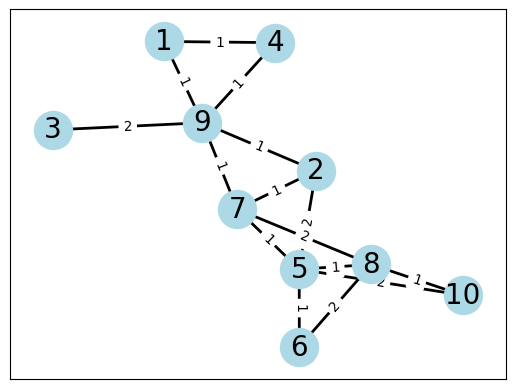

In [92]:
import matplotlib.pyplot as plt # routine to plot the example graph

# some properties
print("node degree")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', linewidths=0.05) # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=2)                               # draw edges

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G, 'weight','trips')
print(edge_labels)
#print("%.2f" % edge_labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()


In [103]:
from datetime import datetime, timedelta

# Define the Van class
class Van:
    def __init__(self, van_id, current_node=1):
        self.id = van_id
        self.current_node = current_node
        self.service_queue = []  # list of (pickup, dropoff)
        self.path = []  # list of nodes to traverse
        self.traversal_remaining_time = 0  # ticks remaining to traverse current edge

    def __repr__(self):
        return f"Van {self.id}: Node {self.current_node}, Queue {self.service_queue}, Path {self.path}"

# Function to assign a van to a customer request based on proximity
def assign_van(vans, start_loc):
    # Find available vans (all have capacity 6, so always available)
    # Choose the van with the shortest distance to pickup location
    available_vans = vans
    if not available_vans:
        return None
    # Find the nearest available van
    nearest_van = min(available_vans, key=lambda v: nx.shortest_path_length(G, v.current_node, start_loc, weight='weight'))
    return nearest_van

# Function to get the path from current node to target node
def get_path(current_node, target_node):
    try:
        path = nx.shortest_path(G, current_node, target_node, weight='weight')
        return path[1:]  # Exclude current_node
    except nx.NetworkXNoPath:
        return []

# Function to move the van
def move_van(van):
    if van.traversal_remaining_time > 0:
        # Currently traversing an edge
        van.traversal_remaining_time -= 1
        if van.traversal_remaining_time == 0:
            # Arrived at next node
            if van.path:
                next_node = van.path.pop(0)
                van.current_node = next_node
                print(f"Van {van.id} arrived at node {next_node}.")

                # Handle drop-offs at this node
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)

                # Handle pickups at this node
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    # After pickup, add path to dropoff
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        # Set traversal_remaining_time for the next edge
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight
    else:
        if van.path:
            # Start moving to next node
            next_node = van.path.pop(0)
            edge_weight = G[van.current_node][next_node]['weight']
            # Set traversal_remaining_time based on edge weight
            van.traversal_remaining_time = edge_weight - 1
            print(f"Van {van.id} starts moving to node {next_node} with traversal time {edge_weight}.")

            if edge_weight == 1:
                # Arrive immediately at next node
                van.current_node = next_node
                print(f"Van {van.id} arrived at node {next_node}.")

                # Handle drop-offs at this node
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)

                # Handle pickups at this node
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    # After pickup, add path to dropoff
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        # Set traversal_remaining_time for the next edge
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight
            else:
                # Set traversal_remaining_time for the current edge
                van.traversal_remaining_time = edge_weight

# Function to handle customer assignments
def handle_customer_requests(vans, requests):
    for pickup, dropoff in requests:
        van = assign_van(vans, pickup)
        if van:
            print(f"Assigning Van {van.id} to customer: Pickup at {pickup}, Drop off at {dropoff}")
            van.service_queue.append((pickup, dropoff))
            # If the van is idle (no path), set path to pickup
            if not van.path:
                path_to_pickup = get_path(van.current_node, pickup)
                van.path += path_to_pickup
                if path_to_pickup:
                    # Set traversal_remaining_time for the first edge
                    next_step = van.path[0]
                    edge_weight = G[van.current_node][next_step]['weight']
                    van.traversal_remaining_time = edge_weight
        else:
            print("No available vans for this request.")

# Main simulation function
def simulate_cab_service(start_time, end_time):
    # Initialize 2 vans at node1
    vans = [Van(van_id=1), Van(van_id=2)]

    # Define customer requests per clock tick
    customer_requests_per_tick = {
        1: [(1, 9), (2, 6)],
        2: [(5, 7), (3, 4)],
        3: [(4, 7), (2, 10)]
    }

    current_time = start_time
    clock_tick = 1

    while current_time < end_time and clock_tick <=3:
        print(f"\nClock tick {clock_tick}: {current_time.strftime('%I:%M %p')}")
        # Assign customer requests for this tick
        requests = customer_requests_per_tick.get(clock_tick, [])
        handle_customer_requests(vans, requests)

        # Move all vans
        for van in vans:
            move_van(van)

        # Print service queues and paths
        for van in vans:
            print(f"S{van.id}: {van.service_queue}")
            print(f"P{van.id}: {van.path}")

        print("-" * 50)

        # Increment time and clock tick
        current_time += timedelta(minutes=1)
        clock_tick +=1

    print("Simulation ended.")

# Run the simulation for 3 ticks from 8:00AM to 8:03AM
start_time = datetime.strptime("08:00", "%H:%M")
end_time = start_time + timedelta(minutes=3)
simulate_cab_service(start_time, end_time)


Clock tick 1: 08:00 AM
Assigning Van 1 to customer: Pickup at 1, Drop off at 9
Assigning Van 1 to customer: Pickup at 2, Drop off at 6
Van 1 arrived at node 9.
Van 1 dropping off customer at node 9.
S1: [(2, 6)]
P1: [2]
S2: []
P2: []
--------------------------------------------------

Clock tick 2: 08:01 AM
Assigning Van 1 to customer: Pickup at 5, Drop off at 7
Assigning Van 1 to customer: Pickup at 3, Drop off at 4
Van 1 starts moving to node 2 with traversal time 1.
Van 1 arrived at node 2.
Van 1 picking up customer at node 2.
S1: [(2, 6), (5, 7), (3, 4)]
P1: [5, 6]
S2: []
P2: []
--------------------------------------------------

Clock tick 3: 08:02 AM
Assigning Van 2 to customer: Pickup at 4, Drop off at 7
Assigning Van 1 to customer: Pickup at 2, Drop off at 10
Van 2 arrived at node 4.
Van 2 picking up customer at node 4.
S1: [(2, 6), (5, 7), (3, 4), (2, 10)]
P1: [5, 6]
S2: [(4, 7)]
P2: [9, 7]
--------------------------------------------------
Simulation ended.


In [20]:
nx.dijkstra_path(G,2,1)  #  Find the length of the shortest path using Dijsktra's algorithm

[2, 9, 1]

In [21]:
nx.astar_path(G,2,1) # Find the length of the shortest path using the A* algorithm.

[2, 9, 1]

In [102]:
from datetime import datetime, timedelta
import networkx as nx

# Define the Van class
class Van:
    def __init__(self, van_id, current_node=1):
        self.id = van_id
        self.current_node = current_node
        self.service_queue = []  # list of (pickup, dropoff)
        self.path = []  # list of nodes to traverse
        self.traversal_remaining_time = 0  # ticks remaining to traverse current edge

    def __repr__(self):
        return f"Van {self.id}: Node {self.current_node}, Queue {self.service_queue}, Path {self.path}"

# Function to assign a van to a customer request based on proximity and lowest ID
def assign_van(vans, start_loc):
    available_vans = vans
    if not available_vans:
        return None
    # Choose van with the shortest distance and lowest ID
    nearest_van = min(available_vans, key=lambda v: (nx.shortest_path_length(G, v.current_node, start_loc, weight='weight'), v.id))
    return nearest_van

# Function to get the path from current node to target node
def get_path(current_node, target_node):
    try:
        path = nx.shortest_path(G, current_node, target_node, weight='weight')
        return path[1:]  # Exclude current_node
    except nx.NetworkXNoPath:
        return []

# Function to move the van and update the path for that van
def move_van(van, path_tracking):
    if van.traversal_remaining_time > 0:
        van.traversal_remaining_time -= 1
        if van.traversal_remaining_time == 0:
            if van.path:
                next_node = van.path.pop(0)
                van.current_node = next_node
                path_tracking.append(next_node)  # Update path tracking
                print(f"Van {van.id} arrived at node {next_node}.")
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight
    else:
        if van.path:
            next_node = van.path.pop(0)
            edge_weight = G[van.current_node][next_node]['weight']
            van.traversal_remaining_time = edge_weight - 1
            print(f"Van {van.id} starts moving to node {next_node} with traversal time {edge_weight}.")
            path_tracking.append(next_node)  # Update path tracking
            if edge_weight == 1:
                van.current_node = next_node
                print(f"Van {van.id} arrived at node {next_node}.")
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight

# Function to handle customer assignments
def handle_customer_requests(vans, requests, paths):
    for pickup, dropoff in requests:
        van = assign_van(vans, pickup)
        if van:
            print(f"Assigning Van {van.id} to customer: Pickup at {pickup}, Drop off at {dropoff}")
            van.service_queue.append((pickup, dropoff))
            if not van.path:
                path_to_pickup = get_path(van.current_node, pickup)
                van.path += path_to_pickup
                paths[van.id - 1] += path_to_pickup  # Update van's path
                if path_to_pickup:
                    next_step = van.path[0]
                    edge_weight = G[van.current_node][next_step]['weight']
                    van.traversal_remaining_time = edge_weight
        else:
            print("No available vans for this request.")

# Main simulation function
def simulate_cab_service(start_time, end_time):
    vans = [Van(van_id=1), Van(van_id=2)]

    # Define customer requests per clock tick (from the tutorial example)
    customer_requests_per_tick = {
        1: [(1, 9), (2, 6)],
        2: [(5, 7), (3, 4)],
        3: [(4, 7), (2, 10)],
        5: [(5, 9)],  # Customer requests continue
        7: [(1, 4)],
        11: [(2, 10)],
        17: [(3, 7)],
    }

    # Path tracking for each van (P1, P2)
    P1 = [1]  # Van 1 starts at node 1
    P2 = [1]  # Van 2 starts at node 1

    current_time = start_time
    clock_tick = 1

    while current_time < end_time:
        print(f"\nClock tick {clock_tick}: {current_time.strftime('%I:%M %p')}")

        # Assign customer requests for this tick
        requests = customer_requests_per_tick.get(clock_tick, [])
        handle_customer_requests(vans, requests, [P1, P2])

        # Move all vans and update their paths
        move_van(vans[0], P1)
        move_van(vans[1], P2)

        # Print service queues and paths
        for van in vans:
            print(f"S{van.id}: {van.service_queue}")
        print(f"P1: {P1}")  # Van 1 path tracking
        print(f"P2: {P2}")  # Van 2 path tracking

        print("-" * 50)

        # Increment time and clock tick
        current_time += timedelta(minutes=1)
        clock_tick += 1

    print("Simulation ended.")

# Run the simulation for 19 ticks from 8:00AM to 8:19AM
start_time = datetime.strptime("08:00", "%H:%M")
end_time = start_time + timedelta(minutes=19)
simulate_cab_service(start_time, end_time)



Clock tick 1: 08:00 AM
Assigning Van 1 to customer: Pickup at 1, Drop off at 9
Assigning Van 1 to customer: Pickup at 2, Drop off at 6
Van 1 arrived at node 9.
Van 1 dropping off customer at node 9.
S1: [(2, 6)]
S2: []
P1: [1, 9, 2, 9]
P2: [1]
--------------------------------------------------

Clock tick 2: 08:01 AM
Assigning Van 1 to customer: Pickup at 5, Drop off at 7
Assigning Van 1 to customer: Pickup at 3, Drop off at 4
Van 1 starts moving to node 2 with traversal time 1.
Van 1 arrived at node 2.
Van 1 picking up customer at node 2.
S1: [(2, 6), (5, 7), (3, 4)]
S2: []
P1: [1, 9, 2, 9, 2]
P2: [1]
--------------------------------------------------

Clock tick 3: 08:02 AM
Assigning Van 2 to customer: Pickup at 4, Drop off at 7
Assigning Van 1 to customer: Pickup at 2, Drop off at 10
Van 2 arrived at node 4.
Van 2 picking up customer at node 4.
S1: [(2, 6), (5, 7), (3, 4), (2, 10)]
S2: [(4, 7)]
P1: [1, 9, 2, 9, 2]
P2: [1, 4, 4]
--------------------------------------------------

Cl

KeyError: 7

Graph is connected


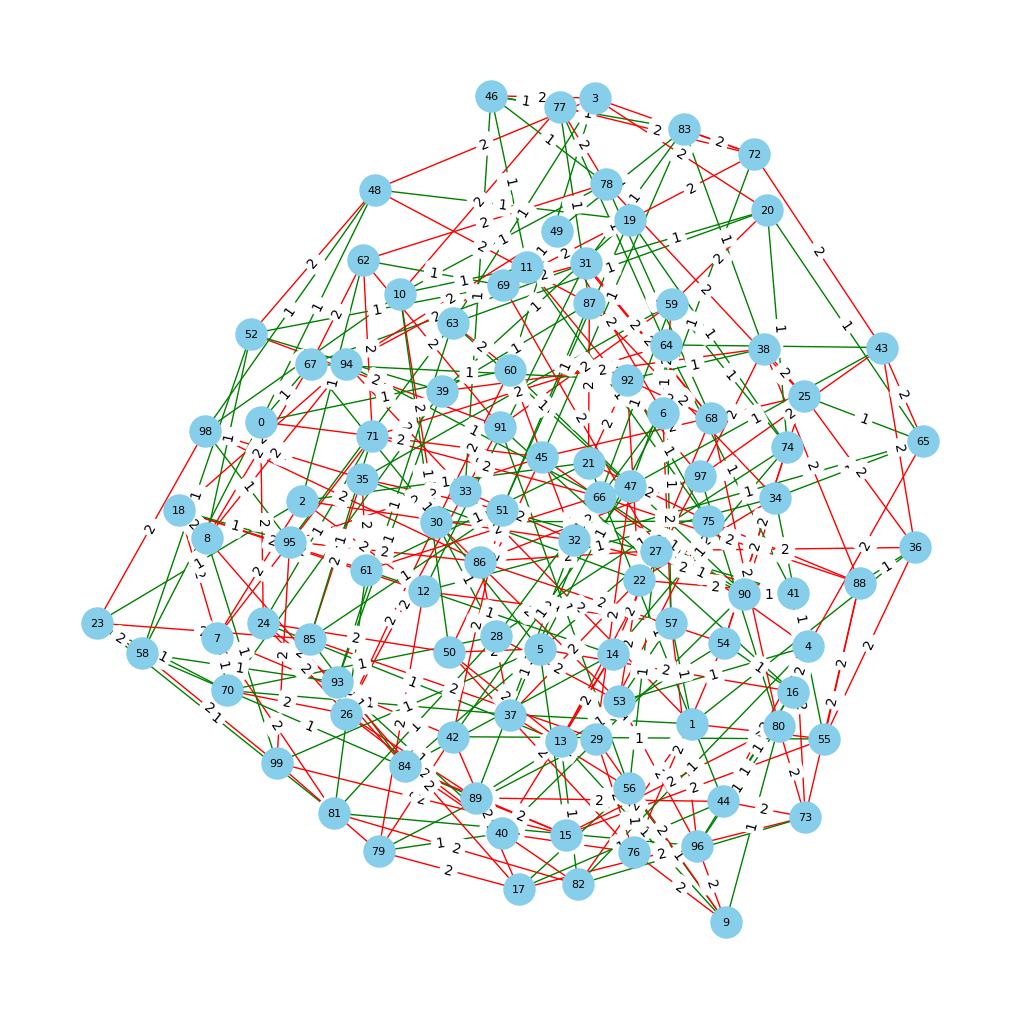

In [104]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Parameters
n_nodes = 100  # Number of nodes
degree = 6     # Connectivity degree

# Generate a random regular graph
G1 = nx.random_regular_graph(degree, n_nodes)

# Assign weights to the edges
# Weight 2 for congested roads, weight 1 for non-congested roads
for u, v in G1.edges():
    # Randomly assign weights: 1 (non-congested) or 2 (congested)
    G1[u][v]['weight'] = random.choice([1, 2])

# Check if the graph is connected
if nx.is_connected(G1):
    print("Graph is connected")
else:
    print("Graph is not connected")

# Draw the graph with weighted edges
edge_colors = ['red' if G1[u][v]['weight'] == 2 else 'green' for u, v in G1.edges()]
pos = nx.spring_layout(G1)  # Position nodes for better visualization

plt.figure(figsize=(10, 10))
nx.draw(G1, pos, node_color='skyblue', with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
edge_labels = nx.get_edge_attributes(G1, 'weight')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.show()


In [105]:
nx.is_connected(G1)      # To check whether G which has at least one path between each pair of nodes.

True

In [106]:
#R3
import networkx as nx
import random
from collections import deque

# Global waiting list
waiting_list = []

# Define the vehicle and customer classes
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.queue = deque()  # List of customers in the vehicle (FIFO)
        self.path = []        # Route the vehicle is taking
        self.current_node = None  # Current position of the vehicle
        self.completed_customers = []  # Store customers who have been picked up and dropped off

    def add_customer(self, customer):
        self.queue.append(customer)

class Customer:
    def __init__(self, pickup, dropoff, request_time):
        self.pickup = pickup
        self.dropoff = dropoff
        self.request_time = request_time
        self.pickup_time = None
        self.dropoff_time = None

# Generate a random customer request
def generate_reservation(time):
    pickup = random.randint(0, 99)  # Random pickup node
    dropoff = random.randint(0, 99)  # Random dropoff node
    while dropoff == pickup:
        dropoff = random.randint(0, 99)  # Ensure dropoff is different
    return Customer(pickup, dropoff, time)

# Assign a customer to an available vehicle
def assign_vehicle(customer, vehicles):
    # Find the first available vehicle (that is not full)
    for vehicle in vehicles:
        if len(vehicle.queue) < 5:  # Assuming the vehicle can hold 5 customers
            vehicle.add_customer(customer)
            return
    # If no vehicle is available, add the customer to a waiting list
    print(f"No available vehicles for customer at time {customer.request_time}, added to waiting list")
    waiting_list.append(customer)

# Process the waiting list and assign customers to vehicles
def process_waiting_list(vehicles):
    global waiting_list  # Access the global waiting list
    for customer in waiting_list[:]:  # Copy the list to modify it during iteration
        for vehicle in vehicles:
            if len(vehicle.queue) < 5:  # Check if the vehicle has space
                vehicle.add_customer(customer)
                waiting_list.remove(customer)
                break  # Assign one customer at a time to available vehicles

# Process vehicle movement and drop off customers
def process_vehicle_movement(vehicle, clock):
    # Ensure vehicle's path is initialized as a list
    if vehicle.path is None:
        vehicle.path = []

    # Check if the vehicle has a customer and no path
    if not vehicle.path and vehicle.queue:
        next_customer = vehicle.queue[0]
        # If this is the first time the customer is being picked up, record pickup time
        if next_customer.pickup_time is None:
            next_customer.pickup_time = clock
            print(f"Customer picked up at time {clock} by Vehicle {vehicle.id}")

        # Calculate the shortest path to the customer's dropoff location
        try:
            vehicle.path = nx.shortest_path(G1, vehicle.current_node, next_customer.dropoff, weight='weight')
            if isinstance(vehicle.path, list):
                print(f"Vehicle {vehicle.id} moving along path: {vehicle.path}")
            else:
                print(f"Error: Expected a list, but got {type(vehicle.path)}. Path: {vehicle.path}")
        except nx.NetworkXNoPath:
            print(f"No path found for vehicle {vehicle.id} to customer {next_customer.dropoff}")
            return  # If no path is found, stop processing for this tick

    # If the path is still empty (no valid path), do nothing
    if not vehicle.path:
        print(f"Vehicle {vehicle.id} has no path at clock {clock}")
        return

    # Move along the path one step
    next_node = vehicle.path.pop(0)  # Safely pop the next node from the list
    vehicle.current_node = next_node

    # Check if any customer needs to be dropped off at this node
    for customer in list(vehicle.queue):
        if customer.dropoff == vehicle.current_node:
            print(f"Dropping off customer at {vehicle.current_node} at time {clock}")
            vehicle.queue.remove(customer)
            customer.dropoff_time = clock  # Record the dropoff time
            vehicle.completed_customers.append(customer)  # Track completed customers

# Simulate a day of operations without Vehicle 0
def simulate_day():
    clock = 0
    # Exclude Vehicle 0 by starting the list from Vehicle 1 (ID 1 to 29)
    vehicles = [Vehicle(i) for i in range(1, 31)]
    total_reservations = random.randint(450, 600) * 10
    global G1
    G1 = nx.random_regular_graph(6, 100)  # Generate a random regular graph with 100 nodes and degree 6

    # Assign weights (1 or 2) to the edges to simulate congestion
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.choice([1, 2])

    # Start the simulation from 8 AM to 6 PM (10 hours)
    while clock < 10 * 60 or any(vehicle.queue for vehicle in vehicles) or waiting_list:
        if clock < 10 * 60:  # During service hours
            for _ in range(total_reservations // 600):  # Generate reservations each minute
                customer = generate_reservation(clock)
                assign_vehicle(customer, vehicles)

        # Process waiting list
        process_waiting_list(vehicles)

        # Move vehicles and process customer drop-offs
        for vehicle in vehicles:
            if vehicle.queue:
                if vehicle.current_node is None:  # Assign a random starting node if not set
                    vehicle.current_node = random.randint(0, 99)
                process_vehicle_movement(vehicle, clock)

            # Display service queues (S) and routing queues (P)
            service_queue = [(c.pickup, c.dropoff) for c in vehicle.queue]  # Pickup and dropoff points
            print(f"Clock {clock}: Vehicle {vehicle.id} Service Queue (S): {service_queue}")
            print(f"Clock {clock}: Vehicle {vehicle.id} Routing Path (P): {vehicle.path}")

        clock += 1  # Increment clock

    return vehicles

# Compute performance metrics
def compute_metrics(vehicles):
    total_waiting_time = 0
    total_service_time = 0
    total_trips = 0

    # Iterate over all completed customers across vehicles
    for vehicle in vehicles:
        for customer in vehicle.completed_customers:
            # Ensure both pickup and dropoff times are recorded before calculating
            if customer.pickup_time is not None and customer.dropoff_time is not None:
                total_waiting_time += customer.pickup_time - customer.request_time
                total_service_time += customer.dropoff_time - customer.pickup_time
                total_trips += 1

    avg_waiting_time = total_waiting_time / total_trips if total_trips > 0 else 0
    avg_service_time = total_service_time / total_trips if total_trips > 0 else 0
    avg_trips = total_trips / len(vehicles) if len(vehicles) > 0 else 0

    return avg_waiting_time, avg_service_time, avg_trips

# Step 1: Run the simulation (without Vehicle 0)
vehicles = simulate_day()  # This now excludes Vehicle 0 (starts from Vehicle 1)

# Step 2: Calculate metrics
avg_waiting_time, avg_service_time, avg_trips = compute_metrics(vehicles)

# Step 3: Output the results
print(f"Average Waiting Time: {avg_waiting_time}")
print(f"Average Service Time: {avg_service_time}")
print(f"Average Trips per Day: {avg_trips}")


Streaming output truncated to the last 5000 lines.
Vehicle 13 moving along path: [34, 19, 50, 87]
Clock 558: Vehicle 13 Service Queue (S): [(97, 87), (57, 28), (24, 64), (7, 3), (6, 56)]
Clock 558: Vehicle 13 Routing Path (P): [19, 50, 87]
Dropping off customer at 20 at time 558
Clock 558: Vehicle 14 Service Queue (S): [(33, 47), (33, 3), (74, 45), (30, 61)]
Clock 558: Vehicle 14 Routing Path (P): []
Dropping off customer at 76 at time 558
Dropping off customer at 76 at time 558
Clock 558: Vehicle 15 Service Queue (S): [(82, 5), (7, 63), (25, 28)]
Clock 558: Vehicle 15 Routing Path (P): []
Clock 558: Vehicle 16 Service Queue (S): [(35, 47), (66, 30), (92, 90), (75, 23), (14, 50)]
Clock 558: Vehicle 16 Routing Path (P): [53, 47]
Clock 558: Vehicle 17 Service Queue (S): [(60, 35), (31, 24), (65, 74), (2, 62), (12, 34)]
Clock 558: Vehicle 17 Routing Path (P): [35]
Dropping off customer at 8 at time 558
Clock 558: Vehicle 18 Service Queue (S): [(53, 24), (72, 41), (15, 76), (61, 23)]
Clock

In [107]:
#R4
import networkx as nx
import random
from collections import deque

# Global waiting list
waiting_list = []

# Define the vehicle and customer classes
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.queue = deque()  # List of customers in the vehicle (FIFO)
        self.path = []        # Route the vehicle is taking
        self.current_node = None  # Current position of the vehicle
        self.completed_customers = []  # Store customers who have been picked up and dropped off

    def add_customer(self, customer):
        self.queue.append(customer)

class Customer:
    def __init__(self, pickup, dropoff, request_time):
        self.pickup = pickup
        self.dropoff = dropoff
        self.request_time = request_time
        self.pickup_time = None
        self.dropoff_time = None

# Generate a random customer request
def generate_reservation(time):
    pickup = random.randint(0, 99)  # Random pickup node
    dropoff = random.randint(0, 99)  # Random dropoff node
    while dropoff == pickup:
        dropoff = random.randint(0, 99)  # Ensure dropoff is different
    return Customer(pickup, dropoff, time)

# Assign a customer to an available vehicle
def assign_vehicle(customer, vehicles):
    # Find the first available vehicle (that is not full)
    for vehicle in vehicles:
        if len(vehicle.queue) < 5:  # Assuming the vehicle can hold 5 customers
            vehicle.add_customer(customer)
            return
    # If no vehicle is available, add the customer to a waiting list
    print(f"No available vehicles for customer at time {customer.request_time}, added to waiting list")
    waiting_list.append(customer)

# Process the waiting list and assign customers to vehicles
def process_waiting_list(vehicles):
    global waiting_list  # Access the global waiting list
    for customer in waiting_list[:]:  # Copy the list to modify it during iteration
        for vehicle in vehicles:
            if len(vehicle.queue) < 5:  # Check if the vehicle has space
                vehicle.add_customer(customer)
                waiting_list.remove(customer)
                break  # Assign one customer at a time to available vehicles

# Process vehicle movement and drop off customers
def process_vehicle_movement(vehicle, clock):
    # Ensure vehicle's path is initialized as a list
    if vehicle.path is None:
        vehicle.path = []

    # Check if the vehicle has a customer and no path
    if not vehicle.path and vehicle.queue:
        next_customer = vehicle.queue[0]
        # If this is the first time the customer is being picked up, record pickup time
        if next_customer.pickup_time is None:
            next_customer.pickup_time = clock
            print(f"Customer picked up at time {clock} by Vehicle {vehicle.id}")

        # Calculate the shortest path to the customer's dropoff location
        try:
            vehicle.path = nx.shortest_path(G1, vehicle.current_node, next_customer.dropoff, weight='weight')
            if isinstance(vehicle.path, list):
                print(f"Vehicle {vehicle.id} moving along path: {vehicle.path}")
            else:
                print(f"Error: Expected a list, but got {type(vehicle.path)}. Path: {vehicle.path}")
        except nx.NetworkXNoPath:
            print(f"No path found for vehicle {vehicle.id} to customer {next_customer.dropoff}")
            return  # If no path is found, stop processing for this tick

    # If the path is still empty (no valid path), do nothing
    if not vehicle.path:
        print(f"Vehicle {vehicle.id} has no path at clock {clock}")
        return

    # Move along the path one step
    next_node = vehicle.path.pop(0)  # Safely pop the next node from the list
    vehicle.current_node = next_node

    # Check if any customer needs to be dropped off at this node
    for customer in list(vehicle.queue):
        if customer.dropoff == vehicle.current_node:
            print(f"Dropping off customer at {vehicle.current_node} at time {clock}")
            vehicle.queue.remove(customer)
            customer.dropoff_time = clock  # Record the dropoff time
            vehicle.completed_customers.append(customer)  # Track completed customers

# Simulate a day of operations without Vehicle 0
def simulate_day():
    clock = 0
    # Exclude Vehicle 0 by starting the list from Vehicle 1 (ID 1 to 29)
    vehicles = [Vehicle(i) for i in range(1, 61)]
    total_reservations = random.randint(450, 600) * 10
    global G1
    G1 = nx.random_regular_graph(6, 100)  # Generate a random regular graph with 100 nodes and degree 6

    # Assign weights (1 or 2) to the edges to simulate congestion
    for (u, v) in G1.edges():
        G1.edges[u, v]['weight'] = random.choice([1, 2])

    # Start the simulation from 8 AM to 6 PM (10 hours)
    while clock < 10 * 60 or any(vehicle.queue for vehicle in vehicles) or waiting_list:
        if clock < 10 * 60:  # During service hours
            for _ in range(total_reservations // 600):  # Generate reservations each minute
                customer = generate_reservation(clock)
                assign_vehicle(customer, vehicles)

        # Process waiting list
        process_waiting_list(vehicles)

        # Move vehicles and process customer drop-offs
        for vehicle in vehicles:
            if vehicle.queue:
                if vehicle.current_node is None:  # Assign a random starting node if not set
                    vehicle.current_node = random.randint(0, 99)
                process_vehicle_movement(vehicle, clock)

            # Display service queues (S) and routing queues (P)
            service_queue = [(c.pickup, c.dropoff) for c in vehicle.queue]  # Pickup and dropoff points
            print(f"Clock {clock}: Vehicle {vehicle.id} Service Queue (S): {service_queue}")
            print(f"Clock {clock}: Vehicle {vehicle.id} Routing Path (P): {vehicle.path}")

        clock += 1  # Increment clock

    return vehicles

# Compute performance metrics
def compute_metrics(vehicles):
    total_waiting_time = 0
    total_service_time = 0
    total_trips = 0

    # Iterate over all completed customers across vehicles
    for vehicle in vehicles:
        for customer in vehicle.completed_customers:
            # Ensure both pickup and dropoff times are recorded before calculating
            if customer.pickup_time is not None and customer.dropoff_time is not None:
                total_waiting_time += customer.pickup_time - customer.request_time
                total_service_time += customer.dropoff_time - customer.pickup_time
                total_trips += 1

    avg_waiting_time = total_waiting_time / total_trips if total_trips > 0 else 0
    avg_service_time = total_service_time / total_trips if total_trips > 0 else 0
    avg_trips = total_trips / len(vehicles) if len(vehicles) > 0 else 0

    return avg_waiting_time, avg_service_time, avg_trips

# Step 1: Run the simulation (without Vehicle 0)
vehicles = simulate_day()  # This now excludes Vehicle 0 (starts from Vehicle 1)

# Step 2: Calculate metrics
avg_waiting_time, avg_service_time, avg_trips = compute_metrics(vehicles)

# Step 3: Output the results
print(f"Average Waiting Time: {avg_waiting_time}")
print(f"Average Service Time: {avg_service_time}")
print(f"Average Trips per Day: {avg_trips}")


Streaming output truncated to the last 5000 lines.
Clock 583: Vehicle 22 Service Queue (S): [(6, 88), (20, 8), (99, 93), (13, 65)]
Clock 583: Vehicle 22 Routing Path (P): []
Dropping off customer at 11 at time 583
Clock 583: Vehicle 23 Service Queue (S): [(94, 74), (9, 8), (99, 16), (80, 39)]
Clock 583: Vehicle 23 Routing Path (P): []
Dropping off customer at 88 at time 583
Clock 583: Vehicle 24 Service Queue (S): [(74, 44), (23, 24), (41, 61)]
Clock 583: Vehicle 24 Routing Path (P): []
Clock 583: Vehicle 25 Service Queue (S): [(87, 25)]
Clock 583: Vehicle 25 Routing Path (P): [89, 1, 25]
Clock 583: Vehicle 26 Service Queue (S): []
Clock 583: Vehicle 26 Routing Path (P): []
Clock 583: Vehicle 27 Service Queue (S): []
Clock 583: Vehicle 27 Routing Path (P): []
Clock 583: Vehicle 28 Service Queue (S): []
Clock 583: Vehicle 28 Routing Path (P): []
Clock 583: Vehicle 29 Service Queue (S): []
Clock 583: Vehicle 29 Routing Path (P): []
Clock 583: Vehicle 30 Service Queue (S): []
Clock 583: V

Graph is connected


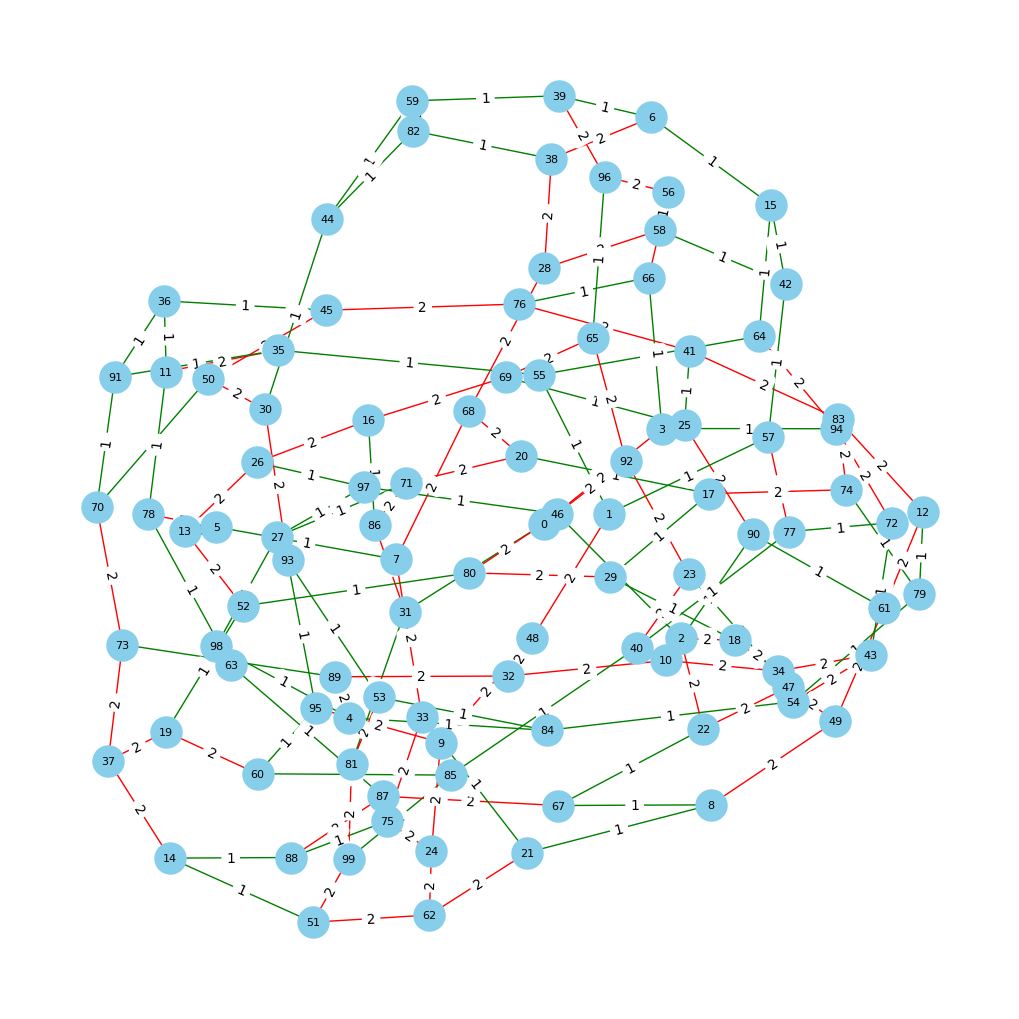

In [108]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Parameters
n_nodes = 100  # Number of nodes
degree = 3     # Connectivity degree

# Generate a random regular graph
G2 = nx.random_regular_graph(degree, n_nodes)

# Assign weights to the edges
# Weight 2 for congested roads, weight 1 for non-congested roads
for u, v in G2.edges():
    # Randomly assign weights: 1 (non-congested) or 2 (congested)
    G2[u][v]['weight'] = random.choice([1, 2])

# Check if the graph is connected
if nx.is_connected(G2):
    print("Graph is connected")
else:
    print("Graph is not connected")

# Draw the graph with weighted edges
edge_colors = ['red' if G2[u][v]['weight'] == 2 else 'green' for u, v in G2.edges()]
pos = nx.spring_layout(G2)  # Position nodes for better visualization

plt.figure(figsize=(10, 10))
nx.draw(G2, pos, node_color='skyblue', with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
edge_labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels)
plt.show()


In [110]:
#R5
import networkx as nx
import random
from collections import deque

# Global waiting list
waiting_list = []

# Define the vehicle and customer classes
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.queue = deque()  # List of customers in the vehicle (FIFO)
        self.path = []        # Route the vehicle is taking
        self.current_node = None  # Current position of the vehicle
        self.completed_customers = []  # Store customers who have been picked up and dropped off

    def add_customer(self, customer):
        self.queue.append(customer)

class Customer:
    def __init__(self, pickup, dropoff, request_time):
        self.pickup = pickup
        self.dropoff = dropoff
        self.request_time = request_time
        self.pickup_time = None
        self.dropoff_time = None

# Generate a random customer request
def generate_reservation(time):
    pickup = random.randint(0, 99)  # Random pickup node
    dropoff = random.randint(0, 99)  # Random dropoff node
    while dropoff == pickup:
        dropoff = random.randint(0, 99)  # Ensure dropoff is different
    return Customer(pickup, dropoff, time)

# Assign a customer to an available vehicle
def assign_vehicle(customer, vehicles):
    # Find the first available vehicle (that is not full)
    for vehicle in vehicles:
        if len(vehicle.queue) < 5:  # Assuming the vehicle can hold 5 customers
            vehicle.add_customer(customer)
            return
    # If no vehicle is available, add the customer to a waiting list
    print(f"No available vehicles for customer at time {customer.request_time}, added to waiting list")
    waiting_list.append(customer)

# Process the waiting list and assign customers to vehicles
def process_waiting_list(vehicles):
    global waiting_list  # Access the global waiting list
    for customer in waiting_list[:]:  # Copy the list to modify it during iteration
        for vehicle in vehicles:
            if len(vehicle.queue) < 5:  # Check if the vehicle has space
                vehicle.add_customer(customer)
                waiting_list.remove(customer)
                break  # Assign one customer at a time to available vehicles

# Process vehicle movement and drop off customers
def process_vehicle_movement(vehicle, clock):
    # Ensure vehicle's path is initialized as a list
    if vehicle.path is None:
        vehicle.path = []

    # Check if the vehicle has a customer and no path
    if not vehicle.path and vehicle.queue:
        next_customer = vehicle.queue[0]
        # If this is the first time the customer is being picked up, record pickup time
        if next_customer.pickup_time is None:
            next_customer.pickup_time = clock
            print(f"Customer picked up at time {clock} by Vehicle {vehicle.id}")

        # Calculate the shortest path to the customer's dropoff location
        try:
            vehicle.path = nx.shortest_path(G2, vehicle.current_node, next_customer.dropoff, weight='weight')
            if isinstance(vehicle.path, list):
                print(f"Vehicle {vehicle.id} moving along path: {vehicle.path}")
            else:
                print(f"Error: Expected a list, but got {type(vehicle.path)}. Path: {vehicle.path}")
        except nx.NetworkXNoPath:
            print(f"No path found for vehicle {vehicle.id} to customer {next_customer.dropoff}")
            return  # If no path is found, stop processing for this tick

    # If the path is still empty (no valid path), do nothing
    if not vehicle.path:
        print(f"Vehicle {vehicle.id} has no path at clock {clock}")
        return

    # Move along the path one step
    next_node = vehicle.path.pop(0)  # Safely pop the next node from the list
    vehicle.current_node = next_node

    # Check if any customer needs to be dropped off at this node
    for customer in list(vehicle.queue):
        if customer.dropoff == vehicle.current_node:
            print(f"Dropping off customer at {vehicle.current_node} at time {clock}")
            vehicle.queue.remove(customer)
            customer.dropoff_time = clock  # Record the dropoff time
            vehicle.completed_customers.append(customer)  # Track completed customers

# Simulate a day of operations without Vehicle 0
def simulate_day():
    clock = 0
    # Exclude Vehicle 0 by starting the list from Vehicle 1 (ID 1 to 29)
    vehicles = [Vehicle(i) for i in range(1, 61)]
    total_reservations = random.randint(450, 600) * 10
    global G2
    G = nx.random_regular_graph(3, 100)  # Generate a random regular graph with 100 nodes and degree 3

    # Assign weights (1 or 2) to the edges to simulate congestion
    for (u, v) in G2.edges():
        G2.edges[u, v]['weight'] = random.choice([1, 2])

    # Start the simulation from 8 AM to 6 PM (10 hours)
    while clock < 10 * 60 or any(vehicle.queue for vehicle in vehicles) or waiting_list:
        if clock < 10 * 60:  # During service hours
            for _ in range(total_reservations // 600):  # Generate reservations each minute
                customer = generate_reservation(clock)
                assign_vehicle(customer, vehicles)

        # Process waiting list
        process_waiting_list(vehicles)

        # Move vehicles and process customer drop-offs
        for vehicle in vehicles:
            if vehicle.queue:
                if vehicle.current_node is None:  # Assign a random starting node if not set
                    vehicle.current_node = random.randint(0, 99)
                process_vehicle_movement(vehicle, clock)

            # Display service queues (S) and routing queues (P)
            service_queue = [(c.pickup, c.dropoff) for c in vehicle.queue]  # Pickup and dropoff points
            print(f"Clock {clock}: Vehicle {vehicle.id} Service Queue (S): {service_queue}")
            print(f"Clock {clock}: Vehicle {vehicle.id} Routing Path (P): {vehicle.path}")

        clock += 1  # Increment clock

    return vehicles

# Compute performance metrics
def compute_metrics(vehicles):
    total_waiting_time = 0
    total_service_time = 0
    total_trips = 0

    # Iterate over all completed customers across vehicles
    for vehicle in vehicles:
        for customer in vehicle.completed_customers:
            # Ensure both pickup and dropoff times are recorded before calculating
            if customer.pickup_time is not None and customer.dropoff_time is not None:
                total_waiting_time += customer.pickup_time - customer.request_time
                total_service_time += customer.dropoff_time - customer.pickup_time
                total_trips += 1

    avg_waiting_time = total_waiting_time / total_trips if total_trips > 0 else 0
    avg_service_time = total_service_time / total_trips if total_trips > 0 else 0
    avg_trips = total_trips / len(vehicles) if len(vehicles) > 0 else 0

    return avg_waiting_time, avg_service_time, avg_trips

# Step 1: Run the simulation (without Vehicle 0)
vehicles = simulate_day()  # This now excludes Vehicle 0 (starts from Vehicle 1)

# Step 2: Calculate metrics
avg_waiting_time, avg_service_time, avg_trips = compute_metrics(vehicles)

# Step 3: Output the results
print(f"Average Waiting Time: {avg_waiting_time}")
print(f"Average Service Time: {avg_service_time}")
print(f"Average Trips per Day: {avg_trips}")


Streaming output truncated to the last 5000 lines.
Dropping off customer at 71 at time 593
Clock 593: Vehicle 26 Service Queue (S): [(22, 98), (2, 87), (75, 47), (34, 80)]
Clock 593: Vehicle 26 Routing Path (P): []
Customer picked up at time 593 by Vehicle 27
Vehicle 27 moving along path: [65, 69, 16, 86, 31, 81]
Clock 593: Vehicle 27 Service Queue (S): [(62, 81), (95, 53), (82, 96), (73, 11), (71, 29)]
Clock 593: Vehicle 27 Routing Path (P): [69, 16, 86, 31, 81]
Dropping off customer at 76 at time 593
Clock 593: Vehicle 28 Service Queue (S): [(71, 25), (8, 7), (95, 97), (19, 22)]
Clock 593: Vehicle 28 Routing Path (P): []
Customer picked up at time 593 by Vehicle 29
Vehicle 29 moving along path: [82, 38, 28, 68, 20, 17]
Clock 593: Vehicle 29 Service Queue (S): [(66, 17), (35, 20), (40, 99), (64, 74), (98, 91)]
Clock 593: Vehicle 29 Routing Path (P): [38, 28, 68, 20, 17]
Customer picked up at time 593 by Vehicle 30
Vehicle 30 moving along path: [86, 31, 81]
Clock 593: Vehicle 30 Servic